In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from pyrosetta import *
init()

%matplotlib inline
%config InlineBackend.figure_format='retina'

core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python36.ubuntu r205 2018.52+release.674a9609eaf 674a9609eaf25635511ef92f90f154dfb7a91256 http://www.pyrosetta.org 2018-12-24T16:26:06
core.init: command: PyRosetta -ex1 -ex2aro -database /home/eking/anaconda3/envs/rosetta/lib/python3.6/site-packages/pyrosetta-2018.52+release.674a9609eaf-py3.6-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-1828817884 seed_offset=0 real_seed=-1828817884
core.init.random: RandomGenerator:init: Normal mode, seed=-1828817884 RG_type=mt19937


In [4]:
def open_random(disto_path):

    # get random proteinnet distrogram 
    f = h5py.File(disto_path)
    random = np.random.choice(list(f.keys()))
    
    arr = f[random][:]
    seq_len = arr.shape[0]
    
    f.close()
    
    print(random)
    print(seq_len)
    print(arr)
    
    return random, seq_len, arr

In [29]:
random, seq_len, arr = open_random('../data/training_30_disto.hdf5')

4A8T_d4a8ta1
148
[[ 0.   3.8  7.2 ... 40.1 42.2 42.3]
 [ 3.8  0.   3.8 ... 36.9 39.1 39.5]
 [ 7.2  3.8  0.  ... 33.6 35.9 36.2]
 ...
 [40.1 36.9 33.6 ...  0.   3.8  6.3]
 [42.2 39.1 35.9 ...  3.8  0.   3.8]
 [42.3 39.5 36.2 ...  6.3  3.8  0. ]]


In [30]:
def plot_distro(arr, name):
    
    p = plt.imshow(arr, cmap='rainbow')
    plt.title(name)
    plt.colorbar(p, label='Distance ($\mathrm{\AA})$')

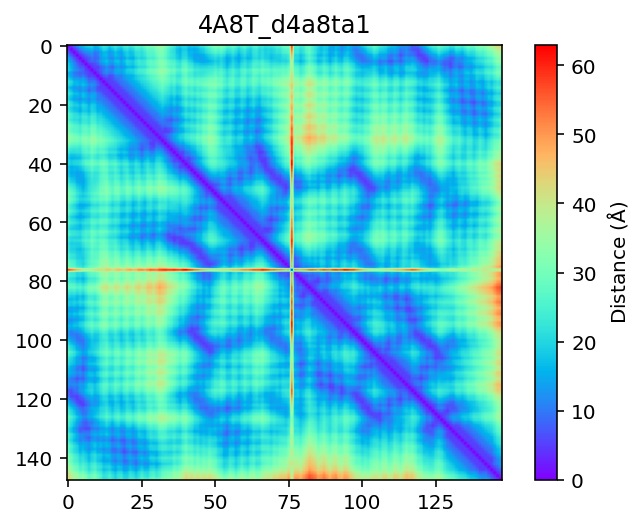

In [31]:
plot_distro(arr, random)

In [32]:
def set_random_torsions(pose):
    
    n_resi = len(pose.residues)
    
    for i in range(1, n_resi+1):
        
        rand_phi = np.random.randint(-180, 180)
        rand_psi = np.random.randint(-180, 180)
        
        pose.set_phi(i, rand_phi)
        pose.set_psi(i, rand_psi)

In [33]:
def get_dist_constraints(arr, slack=0.5):
    
    # get all residue pairs
    # 0-index
    seq_len = arr.shape[0]
    pairs = list(itertools.combinations(range(seq_len), 2))
    
    # all ala pose
    pose = pose_from_sequence('A'*seq_len)
    set_random_torsions(pose)
    pose.dump_pdb('start.pdb')
    
    for pair in pairs:
        
        dist = arr[pair[0], pair[1]]
        
        # resi to 1-index
        res_i = pair[0] + 1
        res_j = pair[1] + 1
        
        # c_alpha
        ca_i = pose.residue(res_i).atom_index('CA')
        ca_j = pose.residue(res_j).atom_index('CA')
        
        # global atom id
        id_i = AtomID(ca_i, res_i)
        id_j = AtomID(ca_j, res_j)
        
        # set constraint
        # ignore missing atoms
        if dist > 0.1:
            func = rosetta.core.scoring.func.HarmonicFunc(dist, slack)
            cst_ij = rosetta.core.scoring.constraints.AtomPairConstraint(id_i, id_j, func)

            pose.add_constraint(cst_ij)
     
    return pose

In [34]:
pose = get_dist_constraints(arr)

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 624 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.703125 seconds.


In [42]:
# print 
#print(pose.constraint_set())

In [35]:
def fold(pose):
    
    # turn on scorefunction constraint
    scorefxn = create_score_function('ref2015_cart')
    scorefxn.set_weight(rosetta.core.scoring.atom_pair_constraint, 1.0)
    
    # relax
    fastrelax = rosetta.protocols.relax.FastRelax(scorefxn, 5)
    fastrelax.cartesian(True)
    fastrelax.dualspace(True)
    fastrelax.max_iter(200)
    fastrelax.apply(pose)
    
    pose.dump_pdb('relaxed.pdb')

In [36]:
fold(pose)

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/rama/fd/all.ramaProb
basic.io.database: Database file opened: scor

core.pack.pack_rotamers: built 148 rotamers at 148 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.optimization.Minimizer: [ WARNING ] LBFGS MAX CYCLES 200 EXCEEDED, BUT FUNC NOT CONVERGED!
protocols.relax.FastRelax: CMD: ramp_repack_min  82436.4  24.1621  24.1621  0.55
protocols.relax.FastRelax: MRP: 1  82436.4  82436.4  24.1621  24.1621
protocols.relax.FastRelax: CMD: accept_to_best  82436.4  24.1621  24.1621  0.55
protocols.relax.FastRelax: CMD: endrepeat  82436.4  24.1621  24.1621  0.55
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 148 rotamers at 148 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.optimization.Minimizer: [ WARNING ] LBFGS MAX CYCLES 200 EXCEEDED, BUT FUNC NOT CONVERGED!
protocols.relax.FastRelax: CMD: ramp_repack_min  82211.8  24.1604  24.1604  0.011
core.pack.task: Packer task: initialize from comma

In [37]:
def check_folding(folded_pdb, arr):
    
    pose = pose_from_file(folded_pdb)
    seq_len = len(pose.residues)
    pairs = list(itertools.combinations(range(seq_len), 2))
    
    # get all pairwise distances and compare to arr
    res = []
    for pair in pairs:
        
        true = arr[pair[0], pair[1]]
        
        ca_res_i = pose.residue(pair[0] + 1).xyz('CA')
        ca_res_j = pose.residue(pair[1] + 1).xyz('CA')
        dist = (ca_res_i - ca_res_j).norm()
        
        res.append([pair[0], pair[1], dist, true])
        
    df = pd.DataFrame(res, columns=['res_i', 'res_j', 'dist', 'true'])
    df['error'] = df['dist'] - df['true']
    
    return df
        
    

In [38]:
df = check_folding('relaxed.pdb', arr)

core.import_pose.import_pose: File 'relaxed.pdb' automatically determined to be of type PDB


In [39]:
df.head()

,res_i,res_j,dist,true,error
0,0,1,3.800979,3.8,0.000979
1,0,2,7.199669,7.2,-0.000331
2,0,3,10.336673,10.4,-0.063327
3,0,4,13.938396,14.1,-0.161604
4,0,5,15.897181,16.0,-0.102819


In [49]:
def fold_stats(df):
    
    # keep only ordered atoms
    subset = df.query("true != 0")
    
    # rmse
    rmse = np.mean(subset['error']**2)
    
    # top 5 largest errors
    subset = subset.assign(abs_err = np.abs(subset['error']))
    top = subset.sort_values(by='abs_err', ascending=False).head()
    
    # plot distribution of errors
    plt.hist(subset['abs_err'], bins=30, density=True)
    plt.title(f'RMSE: {rmse:.3f} A\nMean: {np.mean(subset["abs_err"]):.3f} A')
    plt.ylabel('Density')
    plt.xlabel('Absolute Error (A)')
    plt.axvline(rmse, color='r', label='RMSE')
    plt.legend()
    
    return top[['res_i', 'res_j', 'dist', 'true', 'abs_err']]
    

(-0.5, 5.0)

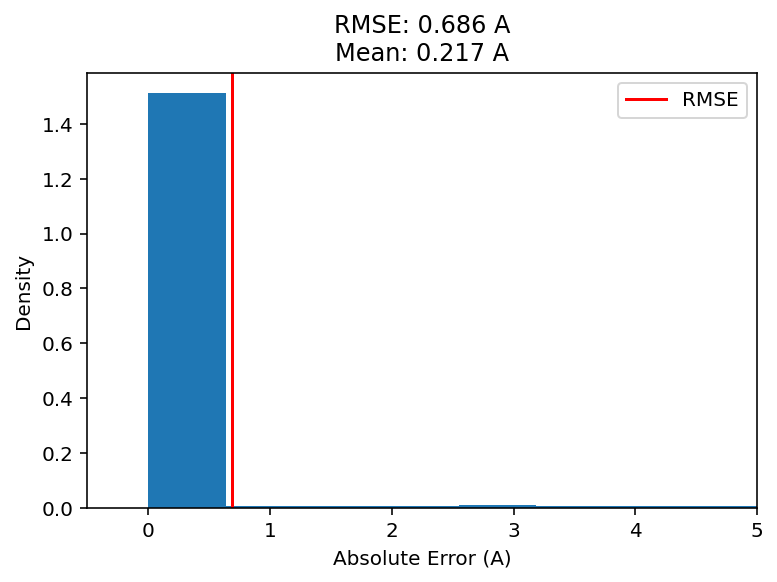

In [52]:
fold_stats(df)
plt.xlim([-0.5, 5])